# Model-Free Summary

Overview: 

* This version is updated on 1/12/2023

* Major updates: 
    - revise model1 "refreshing": remove retrieval, use encoding-only
    - reward probability: random walk is enabled
    - randomness is fixed: reward probability is fixed across simulation
    - parameter `M`: a scale parameter that scales the amount of reward 
        For example, M = 0, mental clock is lowest, agent will purely rely on model-free approach
        When M = 1, mental clock takes the same value as reward
        When M = 2, mental clock = reward * 2
        When M -> +infinite, metal clock is highest, agent will purely rely on model-based approach

Main Takeaways:

* n = 500 is good enough, n = 100 may not work as expected 
    
* actr parameters: 
    - small noise parameter may cause problem: `ans:0.1, egs:0.1` --> high P(stay)
    
    - good parameter set: 
        > `actr_params={'seed':'nil', 'ans':0.2, 'egs':0.5, 'alpha':0.2, 'v':'nil', 'lf':1, 'bll':0.5, 'mas':2}`

    - important: in model1, cannot refresh infinite times, because reward delivery is dependent on time spend ( set refresh-done in goal buffer)


In [3]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)

#from markov_device import *
from markov_simulate_test import Simulation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pandas.api.types as pdtypes


%matplotlib inline

In [4]:
model_name="markov-model1"

main_dir = os.path.dirname(os.getcwd())
dest_dir = os.path.join(os.getcwd(), '__cache__', model_name)
main_dir, dest_dir

('/home/chery/Documents/Github/ACTR-MarkovTask',
 '/home/chery/Documents/Github/ACTR-MarkovTask/analysis/__cache__/markov-model1')

In [5]:
r = 1
task_params={'REWARD': {'B1': r, 'B2': r, 'C1':r, 'C2': r}, 'RANDOM_WALK':'LOAD'}
actr_params={'v':'nil', 'ans':0.2, 'egs':0.2, 'alpha':0.2, 'lf': 0.5, 'bll': 0.5, 'mas':2}

e=25
n=200

In [6]:
try:
    df1_state1stay=pd.read_csv(os.path.join(dest_dir, model_name+'-sim-staydata.csv'), index_col=0)
except:
    Simulation.simulate_stay_probability(model=model_name, epoch=e, n=n, task_params=task_params, actr_params=actr_params, log=dest_dir, verbose=True)
finally:
    df1_state1stay=pd.read_csv(os.path.join(dest_dir, model_name+'-sim-staydata.csv'), index_col=0)

In [7]:
df1stay_aggregate  = df1_state1stay.groupby(['epoch', 
                                             'pre_received_reward', 
                                             'state_frequency'])\
        .agg(state1_stay_mean=('state1_stay', 'mean'),
        state1_stay_sd=('state1_stay', 'std'),
        state1_stay_se=('state1_stay', 'sem')).reset_index()
df1stay_aggregate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   epoch                100 non-null    int64  
 1   pre_received_reward  100 non-null    object 
 2   state_frequency      100 non-null    object 
 3   state1_stay_mean     100 non-null    float64
 4   state1_stay_sd       100 non-null    float64
 5   state1_stay_se       100 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.8+ KB


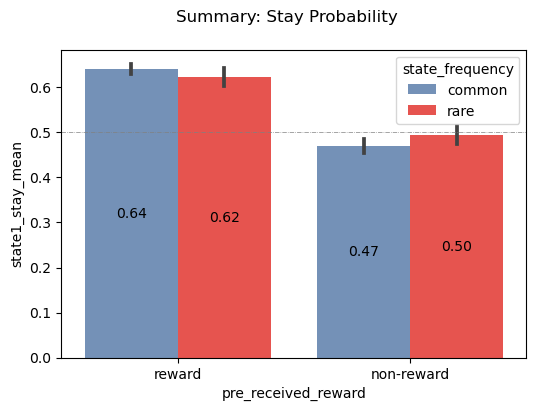

In [8]:
my_palette = sns.color_palette(["#4374B3", "#FF0B04"])

fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Summary: Stay Probability')
sns.barplot(data=df1stay_aggregate, x='pre_received_reward', y='state1_stay_mean', 
            hue='state_frequency', errorbar='se', 
            palette=my_palette, alpha=.8, 
            order = ['reward', 'non-reward'],
            hue_order=['common', 'rare'], 
            ax=ax)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center')
ax.axhline(0.5, color='grey', ls='-.', linewidth=.5) 
plt.show()

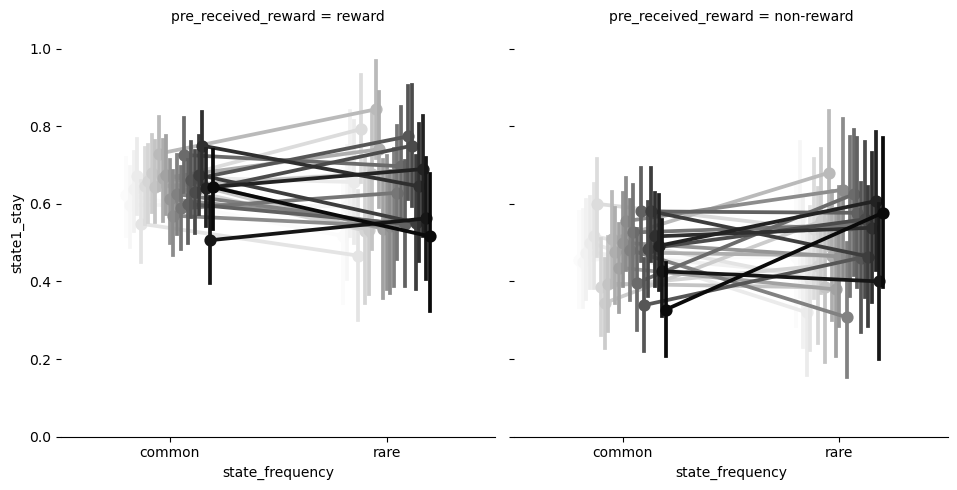

In [9]:
ax = sns.catplot(data=df1_state1stay, x='state_frequency', y='state1_stay', kind='point',
            row=None, col='pre_received_reward',
            margin_titles=True, hue='epoch', palette='Greys', dodge=.4) 
ax.set(ylim=(0, 1.05))
ax.despine(left=True)
ax._legend.remove()
plt.show()

In [10]:
# df1_state1stay[df1_state1stay.apply(lambda x: (x['received_reward']==0 and x['state_frequency']=='rare'), axis=1)]

## Simulation Results: Effect

In [11]:
# df1stay_aggregate

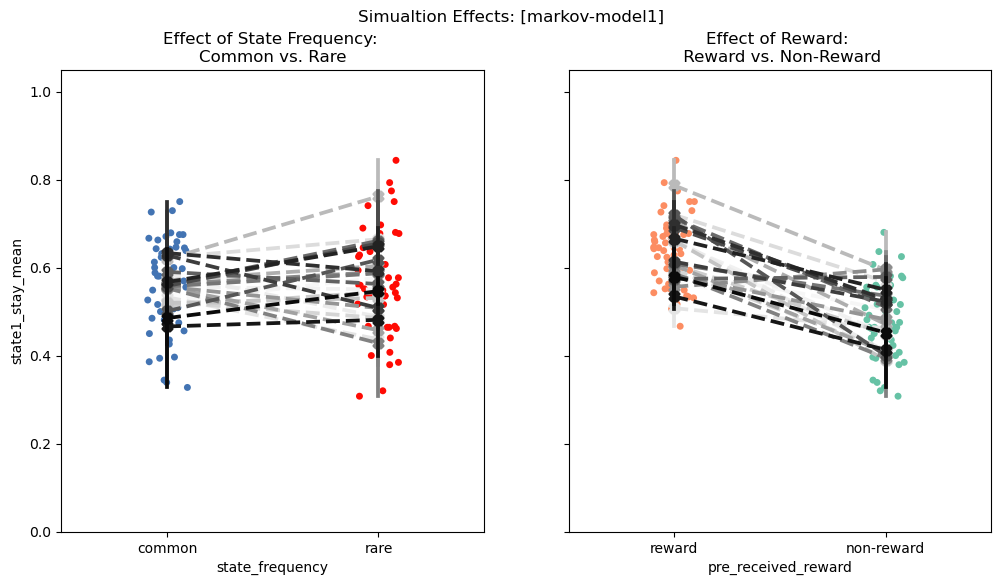

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,6), sharey=True)
fig.suptitle('Simualtion Effects: [%s]' % (model_name))
    
sns.stripplot(data=df1stay_aggregate, x='state_frequency', y='state1_stay_mean', 
            order=['common', 'rare'],  hue='state_frequency', palette=my_palette, ax=axes[0])
sns.pointplot(data=df1stay_aggregate, x='state_frequency', y='state1_stay_mean', 
              order=['common', 'rare'],  hue='epoch', palette='Greys', 
              markers='X', linestyles='--', ax=axes[0]) 

sns.stripplot(data=df1stay_aggregate, x='pre_received_reward', y='state1_stay_mean', 
              order=['reward', 'non-reward'],  hue='pre_received_reward', palette='Set2', ax=axes[1])
sns.pointplot(data=df1stay_aggregate, x='pre_received_reward', y='state1_stay_mean', 
                 order=['reward', 'non-reward'],  hue='epoch', palette='Greys', 
                  markers='X', linestyles='--', ax=axes[1]) 

axes[0].set_ylim(0,1.05)
axes[0].set_title('Effect of State Frequency: \nCommon vs. Rare')
axes[1].set_title('Effect of Reward: \n Reward vs. Non-Reward')
axes[0].get_legend().remove()
axes[1].get_legend().remove()

plt.show()

## Response Time

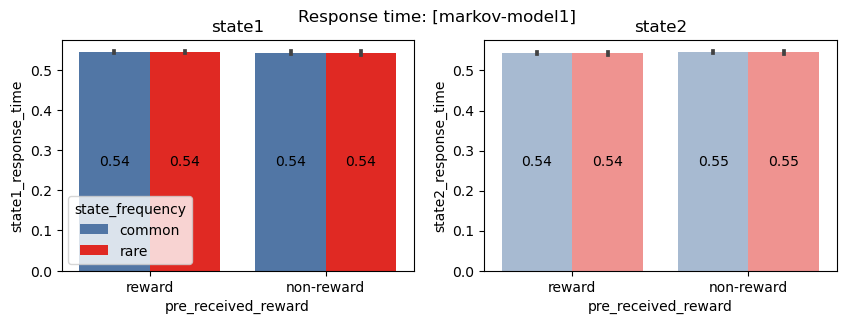

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
fig.suptitle('Response time: [%s]' % (model_name))
sns.barplot(data=df1_state1stay, x='pre_received_reward', y='state1_response_time', hue='state_frequency', palette=my_palette, alpha=1, ax=axes[0])
sns.barplot(data=df1_state1stay, x='pre_received_reward', y='state2_response_time', hue='state_frequency', palette=my_palette, alpha=.5, ax=axes[1])
axes[0].set_title('state1')
axes[1].set_title('state2')
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center')

axes[1].get_legend().remove()
plt.show()

# Learning Performance

In [14]:
df1 = pd.read_csv(os.path.join(dest_dir, model_name+'-sim-logdata.csv'), index_col=0)

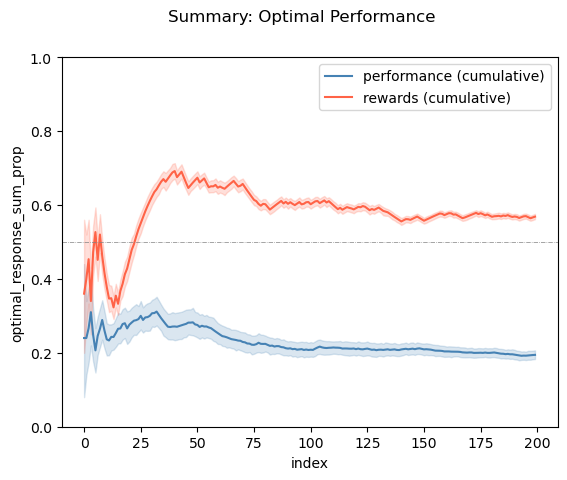

In [15]:
fig, ax = plt.subplots()
fig.suptitle('Summary: Optimal Performance')
sns.lineplot(data=df1, x='index', y='optimal_response_sum_prop',  label='performance (cumulative)', color='steelblue', ax=ax)
sns.lineplot(data=df1, x='index', y='received_reward_sum_prop', label='rewards (cumulative)', color='tomato', ax=ax)

ax.axhline(0.5, color='grey', ls='-.', linewidth=.5) 
ax.set_ylim(0,1)
plt.show()

## ACT-R Traces



In [16]:
df1_utrace = pd.read_csv(os.path.join(dest_dir, model_name+'-actr-udata.csv'), index_col=0)

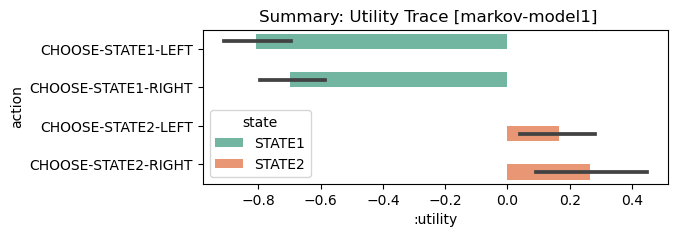

In [17]:
fig, ax = plt.subplots(figsize=(6,2))
fig.suptitle('Summary: Utility Trace [%s]' % model_name) 
sns.barplot(data=df1_utrace, y='action', x=':utility', hue='state', palette='Set2', ax=ax) 
plt.show()

## Activation Trace

In [18]:
df1_atrace = pd.read_csv(os.path.join(dest_dir, model_name+'-actr-adata.csv'), index_col=0)
dfm = Simulation.process_memory_data(df1)
# dfm['state1_memory'] = df1.apply(map_func1, axis=1)
# dfm['state2_memory'] = df1.apply(map_func2, axis=1)

# dfm_count = pd.concat([dfm.groupby(['epoch', 'state1_memory'])['index'].count().reset_index().rename(columns={'state1_memory':'memory', 'index':'trial_count'}), 
#            dfm.groupby(['epoch', 'state2_memory'])['index'].count().reset_index().rename(columns={'state2_memory':'memory', 'index':'trial_count'})], axis=0)

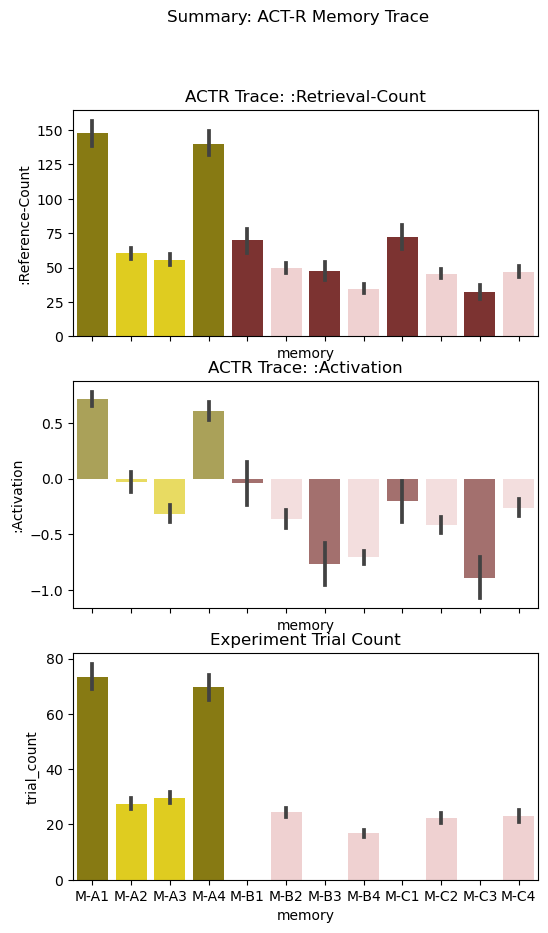

#|Warning: Changing declarative parameters with chunks in dm not supported. |#
#|Warning: Results may not be what one expects. |#
#|Warning: Changing declarative parameters with chunks in dm not supported. |#
#|Warning: Results may not be what one expects. |#


In [27]:
reward_palette1 = sns.color_palette(['#f4cccc', '#882724'])
# my_chunk_palette = sns.color_palette(["#FF0B04", "#F8C4B4", "#F8C4B4", "#FF0B04", "#E6E5A3", "#557153", "#557153", "#E6E5A3", "#B1D0E0", "#1A374D", "#B1D0E0", "#1A374D"])
my_chunk_palette = sns.color_palette(["#9a8900", "#ffe500", "#ffe500", "#9a8900"]+['#882724', '#f4cccc']*4)
chunk_order = df1_atrace['memory'].sort_values().unique()

fig, axes = plt.subplots(3,1, figsize=(6,10), sharex=True)
fig.suptitle('Summary: ACT-R Memory Trace')
sns.barplot(data = df1_atrace, x='memory', y=':Reference-Count', order=chunk_order, palette=my_chunk_palette, ax=axes[0])
sns.barplot(data =df1_atrace, x='memory', y=':Activation', alpha=.7, order=chunk_order, palette=my_chunk_palette, errorbar='se', ax=axes[1])
sns.barplot(data=dfm, x='memory', y='trial_count', order=chunk_order, palette=my_chunk_palette, ax=axes[2])


# axes[0].legend(labelcolor=['#9a8900', '#f4cccc', '#ffe500', '#9a8900'], labels=['Reward', 'Non-Reward', 'Rare', 'Common'])
axes[0].set_title('ACTR Trace: :Retrieval-Count') 
axes[1].set_title('ACTR Trace: :Activation') 
axes[2].set_title('Experiment Trial Count') 

# for ax in axes:
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%.2f', label_type='center')  
plt.show()